# Акустические модели

Акустическая модель - это часть системы автоматического распознавания речи, которая используется для преобразования аудиосигнала речи в последовательность фонем или других единиц речевого звука. Акустическая модель обучается на большом наборе речевых данных, чтобы определить, какие звуки соответствуют конкретным акустическим признакам в аудиосигнале. Эта модель может использоваться вместе с другими компонентами, такими как языковая модель и модель декодирования, чтобы достичь более точного распознавания речи.

В данной работе мы сконцентрируемся на обучении нейросетевых акустических моделей с помощью библиотек torch и torchaudio. Для экспериментов будем использовать базу [TIMIT](https://catalog.ldc.upenn.edu/LDC93s1)

In [1]:
import numpy as np
import time
import torch
import os
from typing import List, Dict, Union, Set, Any
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter
from pathlib import Path
import pandas as pd
import soundfile as sf
import torchaudio
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


/home/testuser/env_p310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загрузка датасета TIMIT

Официальная страница датасета TIMIT 

Для простоты загрузки данных удобнее всего пользоваться копией датасета, выложенной на kaggle 

https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech


In [2]:
!pip3 install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 KB 1.3 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 KB 8.7 MB/s eta 0:00:00
Using legacy 'setup.py install' for kaggle, since package 'wheel' is not installed.
  Running setup.py install for kaggle ... one


In [3]:
# https://github.com/Kaggle/kaggle-api - Docs kaggle 
# Simplest way: go to https://www.kaggle.com/settings , "Create new token" and move it into "~/.kaggle"

!kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech

Dataset URL: https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech
License(s): copyright-authors
100%|███████████████████████████████████████▉| 828M/829M [00:31<00:00, 27.4MB/s]
100%|████████████████████████████████████████| 829M/829M [00:31<00:00, 27.7MB/s]


In [4]:
!unzip -o -q darpa-timit-acousticphonetic-continuous-speech.zip -d timit/

# 1. Подготовка данных для обучения

\TIMIT является одной из самых широко используемых баз данных для изучения систем автоматического распознавания речи. База данных TIMIT содержит произнесения предложений различными дикторами. Каждое произнесение сопровождается его словной и фонетической разметкой.

Для обучения акустической модели нам в первую очередь интересна фонетическая разметка произнесений. Такая разметка сопоставляет фонемы, которые были произнесены диктором, с временными интервалами в записи. Такая разметка позволит нам обучить пофреймовый классификатор, который будет предсказывать сказанную фонему.

## 1.a. Загрузка базы с диска

In [2]:
class TimitDataset(Dataset):
    """Загрузка TIMIT данных с диска"""
    def __init__(self, data_path):
        self.data_path = data_path
        self.uri2wav = {}
        self.uri2text = {}
        self.uri2word_ali = {}
        self.uri2phone_ali = {}
        self._total_audio_samples = None
        self._total_num_words = None
        self._total_num_phones = None
        self._vocab = None
        self._phones = None
        self._phones_prior = None
        
        for d, _, fs in os.walk(data_path):
            for f in fs:
                full_path = f'{d}/{f}'
                if f.endswith('.WAV'):
                    # skip it. Use .wav instead
                    pass
                elif f.endswith('.wav'):
                    stem = Path(f[:-4]).stem # .WAV.wav
                    self.uri2wav[f'{d}/{stem}'] = full_path
                elif f.endswith('.TXT'):
                    stem = Path(f).stem
                    self.uri2text[f'{d}/{stem}'] = full_path
                elif f.endswith('.WRD'):
                    stem = Path(f).stem
                    self.uri2word_ali[f'{d}/{stem}'] = full_path
                elif f.endswith('.PHN'):
                    stem = Path(f).stem
                    self.uri2phone_ali[f'{d}/{stem}'] = full_path
                else:
                    warnings.warn(f"Unknown file type {full_path} . Skip it.")
        
        self.uris = list(sorted(set(self.uri2wav.keys()) \
                                & set(self.uri2text.keys()) \
                                & set(self.uri2word_ali.keys()) \
                                &  set(self.uri2phone_ali.keys())
                               ))
        print(f"Found {len(self.uris)} utterances in {self.data_path}. ", 
              f"{len(self.uri2wav)} wavs, ", 
              f"{len(self.uri2text)} texts, ",
              f"{len(self.uri2word_ali)} word alinments, ",
             f"{len(self.uri2phone_ali)} phone alignments")
    
    def get_uri(self, index_or_uri: Union[str, int]):
        if isinstance(index_or_uri, str):
            uri = index_or_uri
        else:
            uri = self.uris[index_or_uri]
        return uri
    
    def get_audio(self, index_or_uri: Union[str, int]):
        uri = self.get_uri(index_or_uri)
        wav_path = self.uri2wav[uri]
        wav_channels, sr = torchaudio.load(wav_path)
        return wav_channels[0], sr 
        
    def get_text(self, index_or_uri: Union[str, int]):
        """ Return (start_sample, stop_sample, text)"""
        uri = self.get_uri(index_or_uri)
        txt_path = self.uri2text[uri]
        with open(txt_path) as f:
            start, stop, text = f.read().strip().split(maxsplit=2)
            start, stop = int(start), int(stop)
            assert start == 0, f"{txt_path}"
        return start, stop, text
    
    def get_word_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, word), ...]"""
        uri = self.get_uri(index_or_uri)
        wrd_path = self.uri2word_ali[uri]
        with open(wrd_path) as f:
            words = [(int(start), int(stop), word) for start, stop, word in map(str.split, f.readlines())]
        return words
    
    def get_phone_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, phone), ...]"""
        uri = self.get_uri(index_or_uri)
        ph_path = self.uri2phone_ali[uri]
        with open(ph_path) as f:
            phonemes = [(int(start), int(stop), ph) for start, stop, ph in map(str.split, f.readlines())]
        return phonemes
    
    def __getitem__(self, index):
        return {"uri": self.get_uri(index),
                "audio": self.get_audio(index),
                "text": self.get_text(index),
                "word_ali": self.get_word_ali(index),
                "phone_ali": self.get_phone_ali(index)}       

    def __len__(self):
        # TODO
        # верните количество элементов в выборке 
        return len(self.uris)

    def total_audio_samples(self) -> int:
        # TODO
        # верните суммарное количество отсчетов во всем аудио
        if self._total_audio_samples is None:
            self._total_audio_samples = sum([self.get_audio(uri)[0].size().numel() for uri in self.uris])
        return self._total_audio_samples

    def total_num_words(self) -> int:
        # TODO
        # верните суммарное количество слов в словном выравнивании
        if self._total_num_words is None:
            self._total_num_words = sum([len(self.get_word_ali(uri)) for uri in self.uris])
        return self._total_num_words
    
    def total_num_phones(self) -> int:
        # TODO
        # верните суммарное количество фонем в фонемном выравнивании
        if self._total_num_phones is None:
            self._total_num_phones = sum([len(self.get_phone_ali(uri)) for uri in self.uris])
        return self._total_num_phones

    def get_vocab(self) -> Set[str]:
        # TODO
        # верните словарь, состоящий из уникальных слов из выборки 
        if self._vocab is None:
            self._vocab = set()
            for uri in self.uris:
                words = [i[2] for i in self.get_word_ali(uri)]
                self._vocab.update(set(words))
        return self._vocab

    def get_phones(self) -> Set[str]:
        # TODO
        # верните уникальный набор фонем, которые используются в выравнивании
        if self._phones is None:
            self._phones = set()
            for uri in self.uris:
                phones = [i[2] for i in self.get_phone_ali(uri)]
                self._phones.update(set(phones))
        return self._phones

    def phones_prior(self) -> Dict[str, float]:
        # TODO
        # верните мапинг фонемы в их априорные вероятности. 
        if self._phones_prior is None:
            _phones_counter = Counter()
            for uri in self.uris:
                _phones_counter.update([i[2] for i in self.get_phone_ali(uri)])
            self._phones_prior = {p: _phones_counter[p]/_phones_counter.total() for p in _phones_counter}
        return self._phones_prior

In [3]:
def test_timit_dataset_stats():
    test_ds = TimitDataset('timit/data/TEST/')

    print("Len")
    assert len(test_ds) == 1680, f"{len(test_ds)}"

    print("Audio")
    audio_len = test_ds.total_audio_samples()
    assert audio_len == 82986452, f"{audio_len}"

    print("Words")
    words_len = test_ds.total_num_words()
    assert words_len == 14553, f"{words_len}"

    print("Phones")
    phones_len = test_ds.total_num_phones()
    assert phones_len == 64145, f"{phones_len}"

    print("Vocab")
    vocab = test_ds.get_vocab()
    assert len(set(vocab)) == 2378, f"{len(set(vocab))}"

    print("Phones vocab")
    phones = test_ds.get_phones()
    assert len(set(phones)) == 61, f"{len(set(phones))}"
    
    print("Phones prior")
    priors = test_ds.phones_prior()
    assert np.isclose(sum(priors.values()), 1.0), f"sum(priors.values())"
    pmin, pmax = min(priors.keys(), key=priors.get), max(priors.keys(), key=priors.get)
    assert pmin == 'eng', pmin
    assert pmax == 'h#', pmax
    print("Test 1.a passed")

test_timit_dataset_stats()

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Len
Audio
Words
Phones
Vocab
Phones vocab
Phones prior
Test 1.a passed


In [4]:
test_ds = TimitDataset('timit/data/TEST/')
item = test_ds[5]
print(item['uri'])
print(item['text'][2])
display.display(display.Audio(item['audio'][0].numpy(), rate=item['audio'][1]))
print('---words---')
for start, stop, word in item['word_ali']:
    print(word)
    display.display(display.Audio(item['audio'][0][start:stop].numpy(), rate=item['audio'][1]))
    break

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
timit/data/TEST/DR1/FAKS0/SX133
Pizzerias are convenient for a quick lunch.


---words---
pizzerias


## 1.b. Экстрактор фич
Для того чтобы построить акустическую модель, первым делом надо извлечь признаки аудио сигнала. Для распознавания речь принято использовать fbank признаки. fbank/MelSpectrogram признаки получается из амплитудного спектра сигнала путем свертки спекта с треугольными фильтрами в мел-шкале. Есть множество реализаций данных признаков в различных библиотеках (kaldi, librosa, torchaudio) и все они имеют свои особенности. В данной работе мы будем использовать реализацию из библиотеки torchaudio. 

In [5]:
class FeatureExtractor(torch.nn.Module):
    def __init__(
        self,
        sample_rate=16000,
        n_fft=400,
        hop_length=160,
        n_mels=40,
        f_max=7600,
        spec_aug_max_fmask=80,
        spec_aug_max_tmask=80,
    ):
        super().__init__()
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        #TODO
        # инициализируйте обработчик fbank фич из torchaudio
        self.mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        
    def samples2frames(self, num_samples: int) -> int:
        # TODO
        # Верните количество кадров в спектрограмме, соответствующей вавке длиной num_samples
        return num_samples // self.hop_length + 1
    
    @property
    def feats_dim(self):
        # TODO
        # Верните количество извлекаемых фич
        return self.n_mels 
    
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        mel = self.mel_spec(waveform)
        return mel

In [6]:
def test_samples2frames():
    fe = FeatureExtractor()
    for i in tqdm(range(15000, 40000)):
        wav = torch.zeros(i)
        feats = fe(wav)
        assert feats.shape[-2] == fe.feats_dim, f"{i} {feats.shape[-2]=}, {fe.feats_dim}"

        assert feats.shape[-1] == fe.samples2frames(i), f"{i} {feats.shape[-1]=}, {fe.samples2frames(i)}"
        
    print('Test 1.b passed')
test_samples2frames()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:15<00:00, 1647.60it/s]

Test 1.b passed


## 1.с. Таргеты и объединение данных в батчи 

Акустическая Модель (АМ) - пофреймовый классификатор, который предсказывает фонему для каждого кадра аудио. Для обучения AM будем использовать фонемное выравнивание. 

In [7]:
train_ds = TimitDataset('timit/data/TRAIN/')
print(train_ds[0])

# Строим мапинг из написания фонемы в ее id 
phones = train_ds.get_phones() 
phones.remove('pau')
phones.remove('epi')
phones.remove('h#')

# Фонемы паузы должны иметь индекс 0
PHONE2ID = {p:i for i, p in enumerate(['pau'] + list(sorted(phones)))}
PHONE2ID['epi'] = 0
PHONE2ID['h#'] = 0
print(PHONE2ID)

Found 4620 utterances in timit/data/TRAIN/.  4620 wavs,  4620 texts,  4620 word alinments,  4620 phone alignments
{'uri': 'timit/data/TRAIN/DR1/FCJF0/SA1', 'audio': (tensor([ 3.0518e-05, -3.0518e-05,  6.1035e-05,  ..., -3.0518e-05,
        -1.5259e-04, -2.4414e-04]), 16000), 'text': (0, 46797, 'She had your dark suit in greasy wash water all year.'), 'word_ali': [(3050, 5723, 'she'), (5723, 10337, 'had'), (9190, 11517, 'your'), (11517, 16334, 'dark'), (16334, 21199, 'suit'), (21199, 22560, 'in'), (22560, 28064, 'greasy'), (28064, 33360, 'wash'), (33754, 37556, 'water'), (37556, 40313, 'all'), (40313, 44586, 'year')], 'phone_ali': [(0, 3050, 'h#'), (3050, 4559, 'sh'), (4559, 5723, 'ix'), (5723, 6642, 'hv'), (6642, 8772, 'eh'), (8772, 9190, 'dcl'), (9190, 10337, 'jh'), (10337, 11517, 'ih'), (11517, 12500, 'dcl'), (12500, 12640, 'd'), (12640, 14714, 'ah'), (14714, 15870, 'kcl'), (15870, 16334, 'k'), (16334, 18088, 's'), (18088, 20417, 'ux'), (20417, 21199, 'q'), (21199, 22560, 'en'), (225

In [21]:
class FeatsPhoneDataset(TimitDataset):
    def __init__(self, data_path, feature_extractor: FeatureExtractor, phone2id, transforms=None):
        super().__init__(data_path)
        self.feature_extractor = feature_extractor
        self.phone2id = phone2id
        self.transforms = transforms

    def __getitem__(self, index):
        orig_item = super().__getitem__(index)
        wav, sr = orig_item['audio']
        assert sr == self.feature_extractor.sample_rate, f"wrong sr for {index}"
        # подготавливаем пофреймовые фичи
        if self.transforms:
            wav = self.transforms(wav.unsqueeze(0).unsqueeze(0), sample_rate=sr)[0,0,:]
        feats = self.feature_extractor(wav)
        feats = feats.squeeze(dim=0).transpose(0, 1) # time x feats

        # создаем пофреймовое выравнивание 
        targets = torch.zeros(feats.shape[0], dtype=torch.long)
        # TODO 
        # заполните пофреймовое фонемное выравнивание targets idшниками фонем
        # используйте phone_ali 
        for phone_ali in orig_item['phone_ali']:
            start_idx = self.feature_extractor.samples2frames(phone_ali[0])
            end_idx = self.feature_extractor.samples2frames(phone_ali[1])
            targets[start_idx:end_idx] = self.phone2id[phone_ali[2]]

        return {"uri": orig_item["uri"],
                "feats": feats,
                "targets": targets, 
                "src_key_padding_mask": torch.zeros(feats.shape[0], dtype=torch.bool)}

    def collate_pad(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Функция объединения элементов в один батч"""
        # TODO 
        # Реализуйте функцию, которая объединяет несколько item'ов датасета в один батч
        # See collate_fn https://pytorch.org/docs/stable/data.html
        # Входные данные и маску надо вернуть таком формате, в каком работает с данными torch.nn.Transformer
        # targets надо склеить тензор с одной осью. Длина оси будет равна суммарному количеству кадров в батче
        feats = torch.nn.utils.rnn.pad_sequence([s['feats'] for s in batch])
        targets = torch.cat([s['targets'] for s in batch])
        src_key_padding_mask = torch.nn.utils.rnn.pad_sequence([s['src_key_padding_mask'] for s in batch],
                                                               batch_first=True,
                                                               padding_value=True)
        return {'feats': feats, # (Time, Batch, feats)
                'targets': targets, #(SumTime)
                'src_key_padding_mask': src_key_padding_mask, #(Batch, Time)
               }

In [9]:
def test_collate_pad():
    fe = FeatureExtractor()
    test_ds = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)

    for i in range(20):
        targets = test_ds[i]['targets']
        orig_ph_ali = test_ds.get_phone_ali(i)
        targets_set = set(targets.tolist())
        orig_set = set([PHONE2ID[ph] for *_, ph in orig_ph_ali])
        assert targets_set == orig_set, f"{i} \n{targets_set} \n {orig_set} \n {orig_ph_ali}"

    items = [test_ds[i] for i in range(30)]
    batch = test_ds.collate_pad(items)
    assert len(batch['feats'].shape) == 3, batch['feats'].shape
    assert batch['feats'].shape[1] == 30, batch['feats'].shape

    assert len(batch['src_key_padding_mask'].shape) == 2, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[0] == 30, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[1] == batch['feats'].shape[0], f"{batch['feats'].shape} {batch['src_key_padding_mask'].shape}"

    number_nonmasked_frames = (~batch['src_key_padding_mask']).sum()
    assert number_nonmasked_frames == len(batch['targets']), f"{number_nonmasked_frames} != {len(batch['targets'])}"

    accumulated_len = 0
    for i, item in enumerate(items):
        feats = batch['feats'][:, i, :]
        assert torch.isclose(feats.sum(), item['feats'].sum()) , i
        src = batch['src_key_padding_mask'][i, :]
        cutted_feats = feats[~src]
        assert torch.isclose(item['feats'], cutted_feats).all()
        cutted_targets = batch['targets'][accumulated_len: accumulated_len + cutted_feats.shape[0]]
        assert torch.isclose(cutted_targets, item['targets']).all()
        accumulated_len += cutted_feats.shape[0]
    print("Test 1.c passed")

test_collate_pad()

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Test 1.c passed


# 2. Акустическая модель

Обучим TransformerEncoder из torch решать задачу пофреймовой классификации. 

In [10]:
class AModel(nn.Module):
    def __init__(self, feats_dim, out_dim,  dim=128, num_layers=4, ff_dim=256, dropout=0.1, nhead=4, max_len=780):
        super().__init__()
        self.feats_dim = feats_dim
        self.max_len=max_len
        self.input_ff = nn.Linear(feats_dim, dim)
        self.positional_encoding = nn.Embedding(max_len, dim)
        layer = torch.nn.TransformerEncoderLayer(d_model=dim, 
                                                 nhead=nhead, 
                                                 dim_feedforward=ff_dim, 
                                                 dropout=dropout, 
                                                 batch_first=False)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer=layer, num_layers=num_layers)
        
        self.head = nn.Linear(dim, out_dim)

    def forward(self, feats, src_key_padding_mask=None, **kwargs):
        # TODO 
        # реализуйте прямой проход модели.
        # Фичи подаются на первый ff слой, 
        # к результату прибавляются позиционные эмбединги.
        # Далее фреймы обрабатываются трансформером 
        # и финализируются с помощью головы
        x = self.input_ff(feats)
        positional_embedding = self.positional_encoding(torch.arange(x.size(0), device=x.device))
        positional_embedding = positional_embedding.view(x.size(0), 1, x.size(2))
        x += positional_embedding
        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        logits = self.head(x)
        return logits # (Time, Batch, Phones)

## 3. Обучение модели 

In [11]:
# Стандартный пайплайн обучения моделей в pytorch
class Trainer(nn.Module):
    def __init__(self, model, fe, phone2id, device='cuda', opt_cls=torch.optim.Adam, opt_kwargs={'lr':0.0001}):
        super().__init__()
        self.device=device
        self.fe = fe
        self.model = model.to(self.device)
        self.phone2id = phone2id
        self.id2phone = {i:ph for ph,i in phone2id.items()}
        self.optimizer = opt_cls(self.model.parameters(), **opt_kwargs)
        self.criterion = torch.nn.CrossEntropyLoss()
        print(f"{self.model}. {self.device}")

    def to(self, device):
        self.device = device
        return super().to()
        
    def forward(self, batch):
        batch = self.batch_to_device(batch)
        logits = self.model(**batch)
        # TODO
        # реализуйте подсчет loss функции  
        _input = torch.cat([logits[~mask, i, :] for i, mask in enumerate(batch['src_key_padding_mask'])])
        loss = self.criterion(_input, batch['targets'])
        return loss

    def batch_to_device(self, batch):
        return {k: v.to(self.device) for k, v in batch.items()}
        
    def train_one_epoch(self, train_dataloader):
        """ Цикл обучения одной эпохи по всем данным"""
        self.model.train()
        pbar = tqdm(train_dataloader)
        losses = []
        for batch in pbar:
            self.optimizer.zero_grad()
            loss = self.forward(batch)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            pbar.set_description(f"training loss {losses[-1]:.5f}")
        return losses

    def score(self, valid_dataloader) -> List[float]:
        """Подсчет лосса на валидационной выборке"""
        pbar = tqdm(valid_dataloader, desc="Scoring...")
        losses = []
        # TODO 
        # реализуйте функцию, которая подсчитывает лосс на валидационной выборке 
        # losses должен хранить значение ошибки на каждом батче 
        for batch in pbar:
            loss = self.forward(batch)
            losses.append(loss.item())
            # pbar.set_description(f"validation loss {losses[-1]:.5f}")
        return losses

    def fit(self, train_dataloader, epochs, valid_dataloader=None, plot_losses=True):
        """Запуск обучения на данном dataloader"""
        pbar = tqdm(range(epochs))
        per_epoch_train_losses = []
        per_epoch_val_losses = []
        for e in pbar:
            train_loss = np.mean(self.train_one_epoch(train_dataloader))
            per_epoch_train_losses.append(train_loss)
            if valid_dataloader is not None:
                val_loss = np.mean(self.score(valid_dataloader))
                per_epoch_val_losses.append(val_loss)
            if plot_losses:
                display.clear_output()
                self.plot_losses(per_epoch_train_losses, per_epoch_val_losses)
            else:
                val_loss = val_loss if valid_dataloader is not None else float('Nan')
                print(f"train: {train_loss:.5f} | val: {val_loss:.5f}")
        return per_epoch_train_losses, per_epoch_val_losses
    
    def plot_losses(self, train_losses, val_losses=[]):
        plt.title(f"Train test losses (epoch {len(train_losses)})")
        plt.plot(range(len(train_losses)), train_losses)
        if len(val_losses) > 0:
            assert len(train_losses) == len(val_losses)
            plt.plot(range(len(val_losses)), val_losses)
        plt.ylabel("loss")
        plt.xlabel('epoch')
        plt.legend(["train loss", "valid loss"])
        plt.grid(True)
        plt.show()

Found 10 utterances in timit/data/TEST/DR1/FAKS0.  10 wavs,  10 texts,  10 word alinments,  10 phone alignments
AModel(
  (input_ff): Linear(in_features=40, out_features=256, bias=True)
  (positional_encoding): Embedding(780, 256)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (head): Linear(in_features=256, out_features=59, bias=True)
).

  0%|                                                                                                                                                                              | 0/160 [00:00<?, ?it/s]
%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 4.27428: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]

  1%|█                                                                                                                                                                     | 1/160 [00:00<00:48,  3.25it/s]

train: 4.27428 | val: 3.99440



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.98891: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.46it/s]

  1%|██                                                                                                                                                                    | 2/160 [00:00<00:46,  3.42it/s]

train: 3.98891 | val: 3.79001



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.78332: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]

  2%|███                                                                                                                                                                   | 3/160 [00:00<00:44,  3.55it/s]

train: 3.78332 | val: 3.65858



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.65140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]

  2%|████▏                                                                                                                                                                 | 4/160 [00:01<00:41,  3.75it/s]

train: 3.65140 | val: 3.57994



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.57259: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.50it/s]

  3%|█████▏                                                                                                                                                                | 5/160 [00:01<00:39,  3.88it/s]

train: 3.57259 | val: 3.52951



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.52179: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.78it/s]

  4%|██████▏                                                                                                                                                               | 6/160 [00:01<00:38,  4.02it/s]

train: 3.52179 | val: 3.48837



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.48007: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]

  4%|███████▎                                                                                                                                                              | 7/160 [00:01<00:37,  4.12it/s]

train: 3.48007 | val: 3.45146



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.44277: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]

  5%|████████▎                                                                                                                                                             | 8/160 [00:02<00:36,  4.19it/s]

train: 3.44277 | val: 3.42181



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.41310: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

  6%|█████████▎                                                                                                                                                            | 9/160 [00:02<00:35,  4.23it/s]

train: 3.41310 | val: 3.40030



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.39184: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]

  6%|██████████▎                                                                                                                                                          | 10/160 [00:02<00:34,  4.39it/s]

train: 3.39184 | val: 3.38300



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.37491: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]

  7%|███████████▎                                                                                                                                                         | 11/160 [00:02<00:32,  4.52it/s]

train: 3.37491 | val: 3.36574



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.35804: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]

  8%|████████████▍                                                                                                                                                        | 12/160 [00:02<00:32,  4.61it/s]

train: 3.35804 | val: 3.34730



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.33993: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]

  8%|█████████████▍                                                                                                                                                       | 13/160 [00:03<00:31,  4.68it/s]

train: 3.33993 | val: 3.32881



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.32171: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]

  9%|██████████████▍                                                                                                                                                      | 14/160 [00:03<00:30,  4.73it/s]

train: 3.32171 | val: 3.31152



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.30468: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]

  9%|███████████████▍                                                                                                                                                     | 15/160 [00:03<00:30,  4.75it/s]

train: 3.30468 | val: 3.29537



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.28885: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]

 10%|████████████████▌                                                                                                                                                    | 16/160 [00:03<00:30,  4.77it/s]

train: 3.28885 | val: 3.27877



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.27265: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]

 11%|█████████████████▌                                                                                                                                                   | 17/160 [00:03<00:29,  4.79it/s]

train: 3.27265 | val: 3.26032



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.25471: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]

 11%|██████████████████▌                                                                                                                                                  | 18/160 [00:04<00:29,  4.80it/s]

train: 3.25471 | val: 3.24032



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.23524: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]

 12%|███████████████████▌                                                                                                                                                 | 19/160 [00:04<00:29,  4.80it/s]

train: 3.23524 | val: 3.21999



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.21544: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.75it/s]

 12%|████████████████████▋                                                                                                                                                | 20/160 [00:04<00:29,  4.71it/s]

train: 3.21544 | val: 3.19988



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.19579: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]

 13%|█████████████████████▋                                                                                                                                               | 21/160 [00:04<00:29,  4.75it/s]

train: 3.19579 | val: 3.17928



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.17554: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]

 14%|██████████████████████▋                                                                                                                                              | 22/160 [00:04<00:28,  4.77it/s]

train: 3.17554 | val: 3.15709



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.15364: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]

 14%|███████████████████████▋                                                                                                                                             | 23/160 [00:05<00:28,  4.79it/s]

train: 3.15364 | val: 3.13290



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.12968: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]

 15%|████████████████████████▊                                                                                                                                            | 24/160 [00:05<00:28,  4.77it/s]

train: 3.12968 | val: 3.10732



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.10434: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]

 16%|█████████████████████████▊                                                                                                                                           | 25/160 [00:05<00:28,  4.77it/s]

train: 3.10434 | val: 3.08112



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.07837: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]

 16%|██████████████████████████▊                                                                                                                                          | 26/160 [00:05<00:28,  4.76it/s]

train: 3.07837 | val: 3.05407



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.05155: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]

 17%|███████████████████████████▊                                                                                                                                         | 27/160 [00:06<00:27,  4.77it/s]

train: 3.05155 | val: 3.02535



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 3.02304: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]

 18%|████████████████████████████▊                                                                                                                                        | 28/160 [00:06<00:27,  4.78it/s]

train: 3.02304 | val: 2.99486



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.99274: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]

 18%|█████████████████████████████▉                                                                                                                                       | 29/160 [00:06<00:27,  4.79it/s]

train: 2.99274 | val: 2.96339



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.96146: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]

 19%|██████████████████████████████▉                                                                                                                                      | 30/160 [00:06<00:27,  4.76it/s]

train: 2.96146 | val: 2.93154



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.92978: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]

 19%|███████████████████████████████▉                                                                                                                                     | 31/160 [00:06<00:27,  4.72it/s]

train: 2.92978 | val: 2.89893



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.89733: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]

 20%|█████████████████████████████████                                                                                                                                    | 32/160 [00:07<00:27,  4.69it/s]

train: 2.89733 | val: 2.86565



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.86421: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]

 21%|██████████████████████████████████                                                                                                                                   | 33/160 [00:07<00:27,  4.67it/s]

train: 2.86421 | val: 2.83280



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.83154: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]

 21%|███████████████████████████████████                                                                                                                                  | 34/160 [00:07<00:27,  4.65it/s]

train: 2.83154 | val: 2.80119



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.80016: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]

 22%|████████████████████████████████████                                                                                                                                 | 35/160 [00:07<00:26,  4.64it/s]

train: 2.80016 | val: 2.76997



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.76916: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]

 22%|█████████████████████████████████████▏                                                                                                                               | 36/160 [00:07<00:26,  4.61it/s]

train: 2.76916 | val: 2.73900



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.73839: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]

 23%|██████████████████████████████████████▏                                                                                                                              | 37/160 [00:08<00:26,  4.61it/s]

train: 2.73839 | val: 2.70866



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.70828: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]

 24%|███████████████████████████████████████▏                                                                                                                             | 38/160 [00:08<00:26,  4.56it/s]

train: 2.70828 | val: 2.67836



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.67828: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.87it/s]

 24%|████████████████████████████████████████▏                                                                                                                            | 39/160 [00:08<00:27,  4.47it/s]

train: 2.67828 | val: 2.64798



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.64824: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.83it/s]

 25%|█████████████████████████████████████████▎                                                                                                                           | 40/160 [00:08<00:27,  4.41it/s]

train: 2.64824 | val: 2.61772



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.61831: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]

 26%|██████████████████████████████████████████▎                                                                                                                          | 41/160 [00:09<00:27,  4.36it/s]

train: 2.61831 | val: 2.58705



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.58796: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.79it/s]

 26%|███████████████████████████████████████████▎                                                                                                                         | 42/160 [00:09<00:27,  4.32it/s]

train: 2.58796 | val: 2.55637



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.55763: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.63it/s]

 27%|████████████████████████████████████████████▎                                                                                                                        | 43/160 [00:09<00:26,  4.38it/s]

train: 2.55763 | val: 2.52608



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.52768: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.11it/s]

 28%|█████████████████████████████████████████████▍                                                                                                                       | 44/160 [00:09<00:25,  4.48it/s]

train: 2.52768 | val: 2.49568



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.49763: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]

 28%|██████████████████████████████████████████████▍                                                                                                                      | 45/160 [00:09<00:25,  4.55it/s]

train: 2.49763 | val: 2.46538



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.46768: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]

 29%|███████████████████████████████████████████████▍                                                                                                                     | 46/160 [00:10<00:24,  4.60it/s]

train: 2.46768 | val: 2.43526



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.43788: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]

 29%|████████████████████████████████████████████████▍                                                                                                                    | 47/160 [00:10<00:24,  4.64it/s]

train: 2.43788 | val: 2.40540



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.40828: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]

 30%|█████████████████████████████████████████████████▌                                                                                                                   | 48/160 [00:10<00:23,  4.67it/s]

train: 2.40828 | val: 2.37587



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.37903: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]

 31%|██████████████████████████████████████████████████▌                                                                                                                  | 49/160 [00:10<00:23,  4.69it/s]

train: 2.37903 | val: 2.34628



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.34975: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]

 31%|███████████████████████████████████████████████████▌                                                                                                                 | 50/160 [00:11<00:23,  4.70it/s]

train: 2.34975 | val: 2.31714



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.32088: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

 32%|████████████████████████████████████████████████████▌                                                                                                                | 51/160 [00:11<00:23,  4.71it/s]

train: 2.32088 | val: 2.28831



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.29227: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

 32%|█████████████████████████████████████████████████████▋                                                                                                               | 52/160 [00:11<00:22,  4.71it/s]

train: 2.29227 | val: 2.25966



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.26387: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]

 33%|██████████████████████████████████████████████████████▋                                                                                                              | 53/160 [00:11<00:22,  4.72it/s]

train: 2.26387 | val: 2.23135



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.23584: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]

 34%|███████████████████████████████████████████████████████▋                                                                                                             | 54/160 [00:11<00:22,  4.73it/s]

train: 2.23584 | val: 2.20324



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.20800: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]

 34%|████████████████████████████████████████████████████████▋                                                                                                            | 55/160 [00:12<00:22,  4.73it/s]

train: 2.20800 | val: 2.17554



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.18060: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]

 35%|█████████████████████████████████████████████████████████▋                                                                                                           | 56/160 [00:12<00:21,  4.73it/s]

train: 2.18060 | val: 2.14794



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.15327: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

 36%|██████████████████████████████████████████████████████████▊                                                                                                          | 57/160 [00:12<00:21,  4.73it/s]

train: 2.15327 | val: 2.12061



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.12621: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]

 36%|███████████████████████████████████████████████████████████▊                                                                                                         | 58/160 [00:12<00:21,  4.73it/s]

train: 2.12621 | val: 2.09340



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.09927: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]

 37%|████████████████████████████████████████████████████████████▊                                                                                                        | 59/160 [00:12<00:21,  4.73it/s]

train: 2.09927 | val: 2.06652



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.07263: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]

 38%|█████████████████████████████████████████████████████████████▉                                                                                                       | 60/160 [00:13<00:21,  4.73it/s]

train: 2.07263 | val: 2.03987



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.04619: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]

 38%|██████████████████████████████████████████████████████████████▉                                                                                                      | 61/160 [00:13<00:20,  4.73it/s]

train: 2.04619 | val: 2.01357



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 2.02011: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]

 39%|███████████████████████████████████████████████████████████████▉                                                                                                     | 62/160 [00:13<00:20,  4.72it/s]

train: 2.02011 | val: 1.98746



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.99421: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]

 39%|████████████████████████████████████████████████████████████████▉                                                                                                    | 63/160 [00:13<00:20,  4.72it/s]

train: 1.99421 | val: 1.96170



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.96868: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]

 40%|██████████████████████████████████████████████████████████████████                                                                                                   | 64/160 [00:14<00:20,  4.72it/s]

train: 1.96868 | val: 1.93610



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.94329: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

 41%|███████████████████████████████████████████████████████████████████                                                                                                  | 65/160 [00:14<00:20,  4.71it/s]

train: 1.94329 | val: 1.91074



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.91816: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]

 41%|████████████████████████████████████████████████████████████████████                                                                                                 | 66/160 [00:14<00:19,  4.71it/s]

train: 1.91816 | val: 1.88560



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.89325: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.02it/s]

 42%|█████████████████████████████████████████████████████████████████████                                                                                                | 67/160 [00:14<00:19,  4.71it/s]

train: 1.89325 | val: 1.86069



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.86854: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                              | 68/160 [00:14<00:19,  4.71it/s]

train: 1.86854 | val: 1.83607



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.84414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]

 43%|███████████████████████████████████████████████████████████████████████▏                                                                                             | 69/160 [00:15<00:19,  4.71it/s]

train: 1.84414 | val: 1.81166



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.81998: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

 44%|████████████████████████████████████████████████████████████████████████▏                                                                                            | 70/160 [00:15<00:19,  4.71it/s]

train: 1.81998 | val: 1.78757



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.79613: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.03it/s]

 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                           | 71/160 [00:15<00:19,  4.66it/s]

train: 1.79613 | val: 1.76370



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.77250: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.67it/s]

 45%|██████████████████████████████████████████████████████████████████████████▎                                                                                          | 72/160 [00:15<00:19,  4.59it/s]

train: 1.77250 | val: 1.73993



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.74898: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.11it/s]

 46%|███████████████████████████████████████████████████████████████████████████▎                                                                                         | 73/160 [00:15<00:18,  4.63it/s]

train: 1.74898 | val: 1.71625



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.72555: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]

 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                        | 74/160 [00:16<00:18,  4.61it/s]

train: 1.72555 | val: 1.69265



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.70218: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.88it/s]

 47%|█████████████████████████████████████████████████████████████████████████████▎                                                                                       | 75/160 [00:16<00:19,  4.46it/s]

train: 1.70218 | val: 1.66913



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.67890: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.57it/s]

 48%|██████████████████████████████████████████████████████████████████████████████▍                                                                                      | 76/160 [00:16<00:19,  4.32it/s]

train: 1.67890 | val: 1.64578



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.65577: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                     | 77/160 [00:16<00:19,  4.23it/s]

train: 1.65577 | val: 1.62265



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.63288: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.60it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 78/160 [00:17<00:19,  4.17it/s]

train: 1.63288 | val: 1.59975



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.61021: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.63it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 79/160 [00:17<00:19,  4.15it/s]

train: 1.61021 | val: 1.57705



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.58773: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.56it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 80/160 [00:17<00:19,  4.21it/s]

train: 1.58773 | val: 1.55450



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.56537: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 81/160 [00:17<00:18,  4.30it/s]

train: 1.56537 | val: 1.53210



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.54315: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 82/160 [00:18<00:17,  4.40it/s]

train: 1.54315 | val: 1.50991



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.52111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 83/160 [00:18<00:17,  4.50it/s]

train: 1.52111 | val: 1.48799



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.49936: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 84/160 [00:18<00:16,  4.56it/s]

train: 1.49936 | val: 1.46643



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.47799: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.99it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 85/160 [00:18<00:16,  4.60it/s]

train: 1.47799 | val: 1.44560



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.45733: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 86/160 [00:18<00:16,  4.62it/s]

train: 1.45733 | val: 1.42643



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.43841: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 87/160 [00:19<00:15,  4.64it/s]

train: 1.43841 | val: 1.40836



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.42062: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 88/160 [00:19<00:15,  4.67it/s]

train: 1.42062 | val: 1.38601



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.39829: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 89/160 [00:19<00:15,  4.68it/s]

train: 1.39829 | val: 1.36143



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.37366: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 90/160 [00:19<00:14,  4.70it/s]

train: 1.37366 | val: 1.34331



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.35572: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 91/160 [00:19<00:14,  4.70it/s]

train: 1.35572 | val: 1.32549



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.33808: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 92/160 [00:20<00:14,  4.71it/s]

train: 1.33808 | val: 1.30247



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.31498: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 93/160 [00:20<00:14,  4.69it/s]

train: 1.31498 | val: 1.28274



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.29528: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 94/160 [00:20<00:14,  4.70it/s]

train: 1.29528 | val: 1.26595



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.27863: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 95/160 [00:20<00:13,  4.71it/s]

train: 1.27863 | val: 1.24498



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.25760: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.03it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 96/160 [00:21<00:13,  4.66it/s]

train: 1.25760 | val: 1.22482



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.23738: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 97/160 [00:21<00:14,  4.36it/s]

train: 1.23738 | val: 1.20810



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.22080: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 98/160 [00:21<00:13,  4.46it/s]

train: 1.22080 | val: 1.18897



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.20166: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.02it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 99/160 [00:21<00:13,  4.53it/s]

train: 1.20166 | val: 1.16877



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.18135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.99it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 100/160 [00:21<00:13,  4.56it/s]

train: 1.18135 | val: 1.15154



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.16421: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.02it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 101/160 [00:22<00:12,  4.60it/s]

train: 1.16421 | val: 1.13418



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.14693: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 102/160 [00:22<00:12,  4.63it/s]

train: 1.14693 | val: 1.11463



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.12729: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 103/160 [00:22<00:12,  4.66it/s]

train: 1.12729 | val: 1.09614



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.10876: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 104/160 [00:22<00:11,  4.67it/s]

train: 1.10876 | val: 1.07944



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.09215: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 105/160 [00:22<00:11,  4.69it/s]

train: 1.09215 | val: 1.06194



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.07465: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 106/160 [00:23<00:11,  4.70it/s]

train: 1.07465 | val: 1.04331



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.05590: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 107/160 [00:23<00:11,  4.70it/s]

train: 1.05590 | val: 1.02501



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.03749: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 108/160 [00:23<00:11,  4.71it/s]

train: 1.03749 | val: 1.00790



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.02038: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 109/160 [00:23<00:10,  4.71it/s]

train: 1.02038 | val: 0.99139



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 1.00391: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 110/160 [00:24<00:10,  4.72it/s]

train: 1.00391 | val: 0.97453



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.98701: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 111/160 [00:24<00:10,  4.71it/s]

train: 0.98701 | val: 0.95728



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.96969: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 112/160 [00:24<00:10,  4.71it/s]

train: 0.96969 | val: 0.93962



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.95185: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 113/160 [00:24<00:09,  4.71it/s]

train: 0.95185 | val: 0.92211



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.93419: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 114/160 [00:24<00:09,  4.71it/s]

train: 0.93419 | val: 0.90498



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.91691: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 115/160 [00:25<00:09,  4.74it/s]

train: 0.91691 | val: 0.88822



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.90005: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 116/160 [00:25<00:09,  4.77it/s]

train: 0.90005 | val: 0.87172



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.88346: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 117/160 [00:25<00:09,  4.68it/s]

train: 0.88346 | val: 0.85555



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.86721: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 118/160 [00:25<00:09,  4.62it/s]

train: 0.86721 | val: 0.84028



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.85199: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 119/160 [00:25<00:08,  4.59it/s]

train: 0.85199 | val: 0.82802



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.84014: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 120/160 [00:26<00:08,  4.57it/s]

train: 0.84014 | val: 0.82583



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.83968: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 121/160 [00:26<00:08,  4.36it/s]

train: 0.83968 | val: 0.81404



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.82724: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.28it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 122/160 [00:26<00:08,  4.23it/s]

train: 0.82724 | val: 0.78539



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.79721: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 123/160 [00:26<00:08,  4.31it/s]

train: 0.79721 | val: 0.76588



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.77717: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.86it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 124/160 [00:27<00:08,  4.38it/s]

train: 0.77717 | val: 0.76416



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.77649: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 125/160 [00:27<00:07,  4.42it/s]

train: 0.77649 | val: 0.73924



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.75053: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 126/160 [00:27<00:07,  4.45it/s]

train: 0.75053 | val: 0.72711



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.73850: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 127/160 [00:27<00:07,  4.47it/s]

train: 0.73850 | val: 0.71532



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.72659: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 128/160 [00:28<00:07,  4.49it/s]

train: 0.72659 | val: 0.69500



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.70558: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 129/160 [00:28<00:06,  4.50it/s]

train: 0.70558 | val: 0.68752



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.69840: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.82it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 130/160 [00:28<00:06,  4.50it/s]

train: 0.69840 | val: 0.66776



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.67789: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.83it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 131/160 [00:28<00:06,  4.51it/s]

train: 0.67789 | val: 0.66011



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.67063: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 132/160 [00:28<00:06,  4.53it/s]

train: 0.67063 | val: 0.64321



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.65320: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 133/160 [00:29<00:05,  4.57it/s]

train: 0.65320 | val: 0.63188



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.64184: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 134/160 [00:29<00:05,  4.60it/s]

train: 0.64184 | val: 0.61884



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.62865: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 135/160 [00:29<00:05,  4.62it/s]

train: 0.62865 | val: 0.60427



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.61371: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 136/160 [00:29<00:05,  4.66it/s]

train: 0.61371 | val: 0.59418



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.60377: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 137/160 [00:29<00:04,  4.72it/s]

train: 0.60377 | val: 0.57898



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.58802: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 138/160 [00:30<00:04,  4.76it/s]

train: 0.58802 | val: 0.56939



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.57863: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 139/160 [00:30<00:04,  4.79it/s]

train: 0.57863 | val: 0.55590



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.56481: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 140/160 [00:30<00:04,  4.80it/s]

train: 0.56481 | val: 0.54417



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.55288: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 141/160 [00:30<00:03,  4.81it/s]

train: 0.55288 | val: 0.53351



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.54222: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.18it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 142/160 [00:31<00:03,  4.82it/s]

train: 0.54222 | val: 0.52026



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.52848: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.18it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 143/160 [00:31<00:03,  4.83it/s]

train: 0.52848 | val: 0.50988



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.51810: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 144/160 [00:31<00:03,  4.84it/s]

train: 0.51810 | val: 0.49814



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.50613: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 145/160 [00:31<00:03,  4.85it/s]

train: 0.50613 | val: 0.48662



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.49436: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 146/160 [00:31<00:02,  4.86it/s]

train: 0.49436 | val: 0.47632



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.48401: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 147/160 [00:32<00:02,  4.86it/s]

train: 0.48401 | val: 0.46482



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.47221: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 148/160 [00:32<00:02,  4.85it/s]

train: 0.47221 | val: 0.45478



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.46211: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 149/160 [00:32<00:02,  4.85it/s]

train: 0.46211 | val: 0.44415



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.45127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 150/160 [00:32<00:02,  4.85it/s]

train: 0.45127 | val: 0.43380



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.44071: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 151/160 [00:32<00:01,  4.85it/s]

train: 0.44071 | val: 0.42398



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.43081: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.64it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 152/160 [00:33<00:01,  4.74it/s]

train: 0.43081 | val: 0.41365



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.42025: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 153/160 [00:33<00:01,  4.70it/s]

train: 0.42025 | val: 0.40408



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.41054: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.79it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 154/160 [00:33<00:01,  4.67it/s]

train: 0.41054 | val: 0.39457



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.40094: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 155/160 [00:33<00:01,  4.65it/s]

train: 0.40094 | val: 0.38472



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.39088: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 156/160 [00:33<00:00,  4.64it/s]

train: 0.39088 | val: 0.37551



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.38153: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 157/160 [00:34<00:00,  4.63it/s]

train: 0.38153 | val: 0.36667



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.37259: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 158/160 [00:34<00:00,  4.62it/s]

train: 0.37259 | val: 0.35736



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.36308: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 159/160 [00:34<00:00,  4.64it/s]

train: 0.36308 | val: 0.34857



%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]
training loss 0.35414: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:34<00:00,  4.60it/s]


train: 0.35414 | val: 0.34013


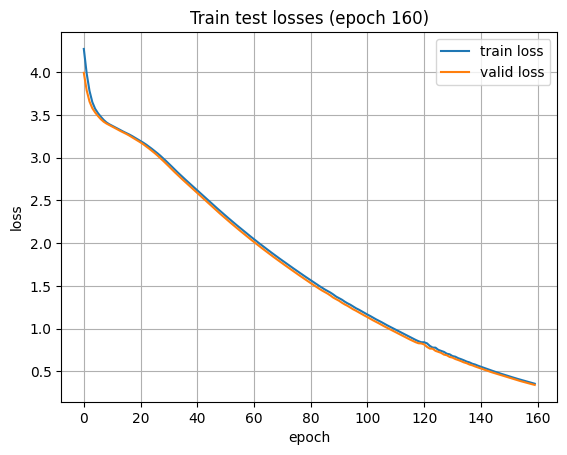

Scoring...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 108.85it/s]

Test 3.a passed


In [102]:
def overfit_one_batch_check():
    # Для проверки работоспособности кода обучения удоно использовать тест модели на overfit 
    # Для этого запускается обучение на одном батче данных. 
    # Если код написан правильно, то модель обязана выучить выучить все примеры из этого батча наизусть. 
    fe = FeatureExtractor()
    train_dataset = FeatsPhoneDataset('timit/data/TEST/DR1/FAKS0', feature_extractor=fe, phone2id=PHONE2ID)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_pad)
    test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, collate_fn=train_dataset.collate_pad)

    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim, 
                                   out_dim=max(PHONE2ID.values()) + 1,  
                                   dim=256, 
                                   num_layers=6, 
                                   ff_dim=512, 
                                   dropout=0.0, 
                                   nhead=8), 
                      fe=fe, 
                      phone2id=PHONE2ID, device='cuda')
   
    # only one batch. The model must learn it by heart
    losses, val_losses = trainer.fit(train_dataloader, 160, valid_dataloader=test_dataloader, plot_losses=False)

    trainer.plot_losses(losses, val_losses)

    val_loss = np.mean(trainer.score(test_dataloader))
    
    assert val_loss < 0.5, f"{val_loss}. Model doesn't train well" 
    print(f"Test 3.a passed")

overfit_one_batch_check()

In [30]:
from torch_audiomentations import Compose, Gain, PolarityInversion, AddColoredNoise, ApplyImpulseResponse, AddBackgroundNoise

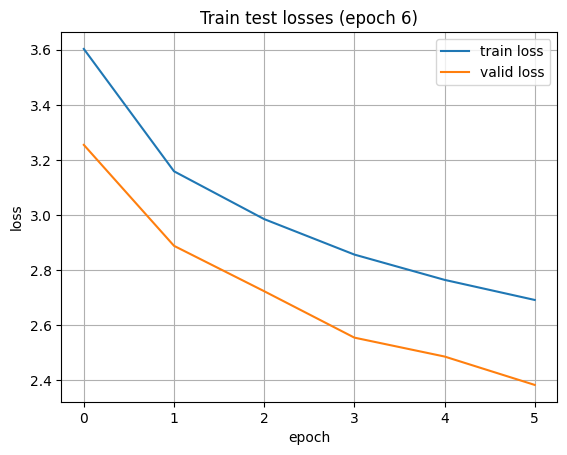

  6%|█████████▊                                                                                                                                                          | 6/100 [07:14<1:53:03, 72.17s/it]
%|                                                                                                                                                                               | 0/73 [00:00<?, ?it/s]
ining loss 2.66501:  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 62/73 [00:44<00:07,  1.48it/s]

In [ ]:
def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    augmentations = Compose(
        transforms=[
            ApplyImpulseResponse(ir_paths='simulated_rirs', p=0.25),
            AddBackgroundNoise(background_paths='musan16', min_snr_in_db=0.0, max_snr_in_db=15.0, p=0.25),
            AddColoredNoise(p=0.5)
        ]
    )
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID, transforms=augmentations)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, 
                                                   num_workers=4, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                                  num_workers=4, collate_fn=test_dataset.collate_pad, shuffle=False)

    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim,
                                   out_dim=max(PHONE2ID.values())+1,
                                   dim=128,
                                   num_layers=8,
                                   ff_dim=256,
                                   dropout=0.2,
                                   nhead=8),
                      fe=fe,
                      phone2id=PHONE2ID, device='cuda:3', opt_cls=torch.optim.AdamW, opt_kwargs={'lr': 0.001})

    per_epoch_train_losses, per_epoch_val_losses = trainer.fit(train_dataloader, epochs=100, valid_dataloader=test_dataloader, plot_losses=True)
    return trainer.to('cpu'), per_epoch_train_losses, per_epoch_val_losses

results, per_epoch_train_losses, per_epoch_val_losses = experiment()

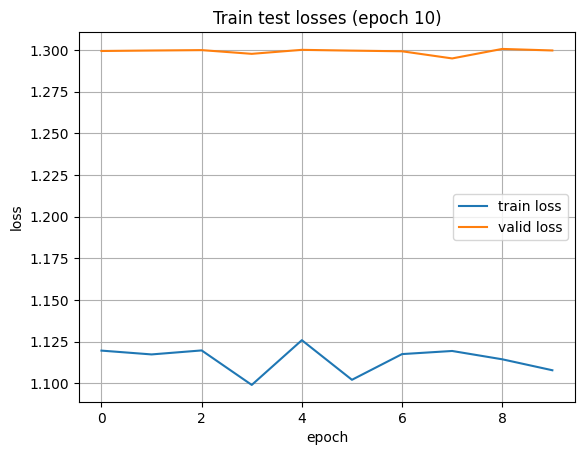

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [12:33<00:00, 75.39s/it]


In [50]:
def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    augmentations = Compose(
        transforms=[
            ApplyImpulseResponse(ir_paths='simulated_rirs', p=0.1),
            AddBackgroundNoise(background_paths='musan16', min_snr_in_db=0.0, max_snr_in_db=15.0, p=0.1),
            AddColoredNoise(p=0.1)
        ]
    )
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID, transforms=augmentations)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, 
                                                   num_workers=4, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                                  num_workers=4, collate_fn=test_dataset.collate_pad, shuffle=False)

    trainer = Trainer(model=results.model,
                      fe=fe,                                                # SGD?
                      phone2id=PHONE2ID, device='cuda:3', opt_cls=torch.optim.SGD, opt_kwargs={'lr': 0.00001})

    per_epoch_train_losses, per_epoch_val_losses = trainer.fit(train_dataloader, epochs=10, valid_dataloader=test_dataloader, plot_losses=True)
    return trainer.to('cpu'), per_epoch_train_losses, per_epoch_val_losses

results, per_epoch_train_losses, per_epoch_val_losses = experiment()

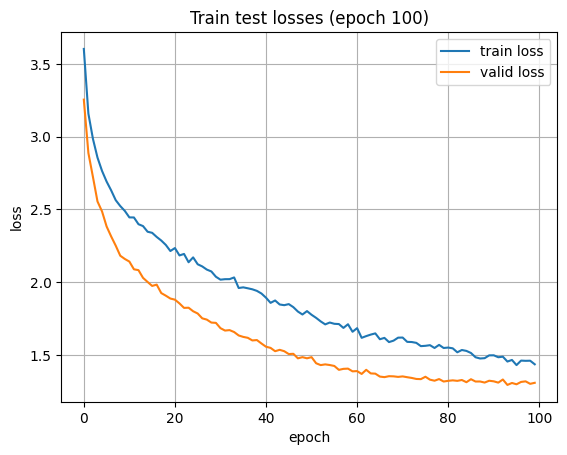

In [41]:
# train
results.plot_losses(per_epoch_train_losses, per_epoch_val_losses)

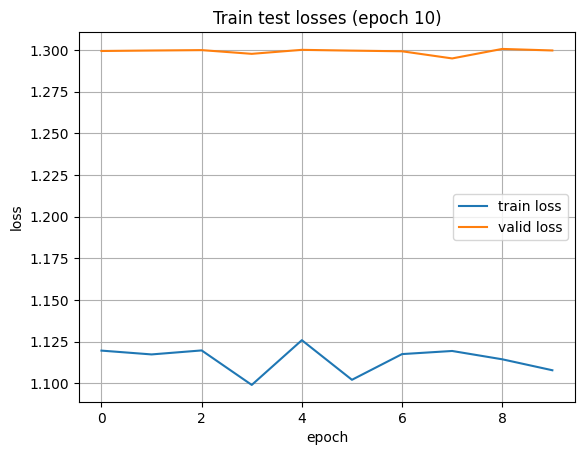

In [53]:
# tuning
results.plot_losses(per_epoch_train_losses, per_epoch_val_losses)

In [42]:
torch.save(results, 'baseline.trainer')

In [52]:
torch.save(results, 'final.trainer')

# Основное задание (12 баллов)
Надо улучшить бейзлайн так, чтобы значение loss на валидации было менее 1.9 

**Дополнительное задание** (4 балла): Улучшите loss до 1.3 

In [51]:
def test_trained_model(trainer):
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=trainer.fe, phone2id=trainer.phone2id)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)
    loss = np.mean(trainer.score(test_dataloader))
    print(f"Test loss is {loss}")
    assert loss < 1.8, "Main task failed"
    print(f"Main task is done! (12 points)")
    if loss <= 1.3:
        print(f"Additional task is done! (+4 points)")

test_trained_model(results.to('cuda:3'))

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments


Scoring...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1680/1680 [00:23<00:00, 70.38it/s]

Test loss is 1.2942394560114259
Main task is done! (12 points)
Additional task is done! (+4 points)


---